# Statistical Testing

Structure

- Notebook Preparation

- [Statistical Testing](##statistical-testing)
    - Mann-Kendall Tests
        - Month
        - Elevation & Month
        - Country

- [Visualisations](##visualisations)
    - Man-Kendall Test Results
        - Month
        - Month & Elevation
        - Country

In [20]:
# Import Packages

import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import plotly.express as px
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pymannkendall as mk
from pathlib import Path


In [21]:
# Files & Directories

NB_DIR = Path.cwd()         # Notebook Directory
REPO_ROOT = NB_DIR.parent   # Main Directory

snow_recordings = pd.read_csv(REPO_ROOT/'data/cleaned/snow_recordings.csv')

snow_recordings.head(2)

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry,elevation_band
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.189784505 2631133.4129758803),Mid Elevation
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.910481082 2631072.9686830333),High Elevation



## Mann_Kendal Test


- Output 
    - n : 
        - number of years tested for that group.
    - trend & p :
        - statistical significance of a monotonic increase/decrease.
    - tau :
        - strength of the monotonic relationship (direction via sign).
    - slope_per_year/decade :
        - estimated rate of change (Sen’s slope) in your units (e.g., cm of snow depth per year/decade).

In [22]:
# Empty Results List
results = []

# 1) aggregate: mean snow depth per month-year
month_year = (snow_recordings
              .groupby(['month', 'year'])['hnsum']
              .mean()
              .reset_index())

for m, g in month_year.groupby('month'):
    # 2) extract series for this month
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:  # simple guard
        results.append({'month': m, 'n': len(x), 'trend': 'insufficient', 'p': np.nan,
                        'tau': np.nan, 'slope_per_year': np.nan})
        continue

    # 3) run MK (original)
    res = mk.original_test(x)

    # 4) store
    results.append({
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_month_simple = pd.DataFrame(results).sort_values('month').reset_index(drop=True)
mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,1,84,no trend,0.229588,-0.089501,-0.184386,-1.843855
1,2,84,no trend,0.141065,-0.109581,-0.191993,-1.919928
2,3,84,no trend,0.656858,-0.033276,-0.056732,-0.567322
3,4,84,decreasing,0.039492,-0.153184,-0.165556,-1.655558
4,5,84,decreasing,0.000003,-0.348824,-0.109625,-1.096252
5,11,84,no trend,0.446640,-0.056799,-0.075344,-0.753443
6,12,84,no trend,0.201009,-0.095238,-0.194385,-1.943854


In [23]:

rows = []

# 1) aggregate: mean snow depth per (elev_band, month, year)
df_agg = (snow_recordings
          .groupby(['elevation_band','month','year'])['hnsum']
          .mean()
          .reset_index())

for (band, m), g in df_agg.groupby(['elevation_band','month']):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:
        rows.append({'elevation_band': band, 'month': m, 'n': len(x),
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # 3) MK (original to start; you can switch to hamed_rao if needed)
    res = mk.original_test(x)

    # 4) store
    rows.append({
        'elevation_band': band,
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_elev_month_simple = pd.DataFrame(rows).sort_values(['elevation_band','month']).reset_index(drop=True)
mk_elev_month_simple


,elevation_band,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,High Elevation,1,84,no trend,4.329188e-01,-0.058520,-0.169975,-1.699746
1,High Elevation,2,84,no trend,8.420359e-02,-0.128514,-0.317632,-3.176317
2,High Elevation,3,84,no trend,6.182457e-01,-0.037292,-0.107042,-1.070419
3,High Elevation,4,84,no trend,6.766365e-02,-0.135972,-0.250584,-2.505841
4,High Elevation,5,84,decreasing,2.721635e-07,-0.382100,-0.393079,-3.930788
5,High Elevation,11,84,no trend,3.023325e-01,-0.076879,-0.164565,-1.645654
6,High Elevation,12,84,no trend,3.170495e-01,-0.074584,-0.228709,-2.287093
7,Low Elevation,1,84,no trend,3.721930e-01,-0.066552,-0.085701,-0.857011
8,Low Elevation,2,84,no trend,7.280802e-01,-0.026104,-0.035522,-0.355220
9,Low Elevation,3,84,no trend,5.289019e-01,0.047045,0.027171,0.271709


In [24]:

rows = []

# 1) aggregate: mean snow depth per (country, year)
df_agg = (snow_recordings
          .groupby(['country','year'])['hnsum']
          .mean()
          .reset_index())

for c, g in df_agg.groupby('country'):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)

    if n < 15:
        rows.append({'country': c, 'n': n, 'variant': 'original',
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # 3b) MK Hamed–Rao (autocorr-adjusted)
    res2 = mk.hamed_rao_modification_test(x)
    rows.append({'country': c, 'n': n, 'variant': 'hamed_rao',
                 'trend': res2.trend, 'p': res2.p, 'tau': res2.Tau,
                 'slope_per_year': res2.slope, 'slope_per_decade': res2.slope*10})

mk_country_simple = pd.DataFrame(rows).sort_values(['country','variant']).reset_index(drop=True)
mk_country_simple


,country,n,variant,trend,p,tau,slope_per_year,slope_per_decade
0,Austria,47,hamed_rao,decreasing,0.014395,-0.180389,-0.213336,-2.133362
1,France,61,hamed_rao,no trend,0.513495,0.057923,0.088097,0.880971
2,Germany,83,hamed_rao,no trend,0.531771,0.052013,0.052509,0.525091
3,Italy,48,hamed_rao,no trend,0.063226,-0.186170,-0.353379,-3.533788
4,Slovenia,59,hamed_rao,decreasing,0.004355,-0.255406,-0.245027,-2.450269
5,Switzerland,84,hamed_rao,no trend,0.087017,-0.127367,-0.108081,-1.080809


## Visualisations

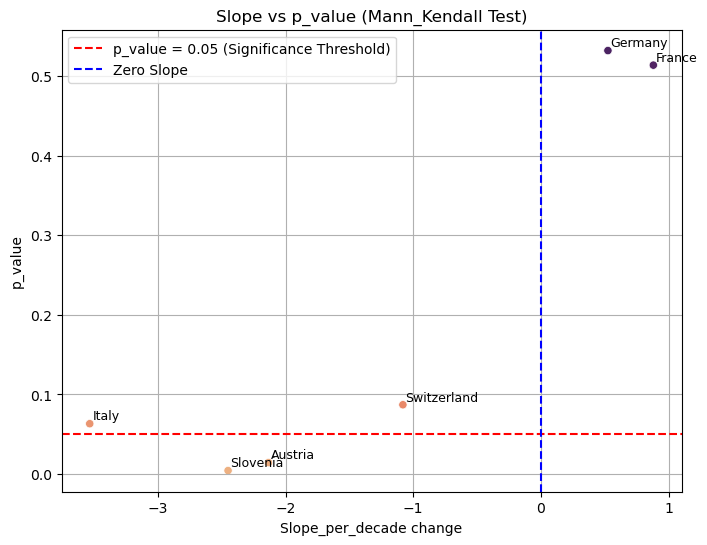

In [25]:
fig1, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_country_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the country name
for i, row in mk_country_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['country'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

In [26]:
month_labels = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    11:'Nov',
    12:'Dec'
}

def get_month_name(month_number):
    """
    Converts a month number to an abbreviated month name using a custom dictionary

    Args:
        month_number (int): The number representing the month (1 for January, 12 for December).

    Returns:
        str: The abbreviated name of the month, or "Invalid month number" if out of range.
    """
    if 1 <= month_number <= 12:
        return month_labels[month_number]
    else:
        return "Invalid month number"


mk_month_simple['month_name'] = mk_month_simple['month'].apply(get_month_name)

mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade,month_name
0,1,84,no trend,0.229588,-0.089501,-0.184386,-1.843855,Jan
1,2,84,no trend,0.141065,-0.109581,-0.191993,-1.919928,Feb
2,3,84,no trend,0.656858,-0.033276,-0.056732,-0.567322,Mar
3,4,84,decreasing,0.039492,-0.153184,-0.165556,-1.655558,Apr
4,5,84,decreasing,0.000003,-0.348824,-0.109625,-1.096252,May
5,11,84,no trend,0.446640,-0.056799,-0.075344,-0.753443,Nov
6,12,84,no trend,0.201009,-0.095238,-0.194385,-1.943854,Dec


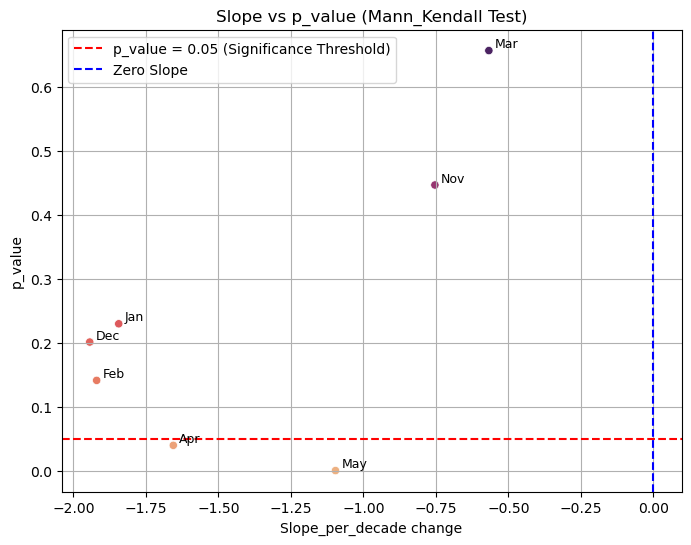

In [27]:

fig, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_month_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the month name
for i, row in mk_month_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['month_name'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

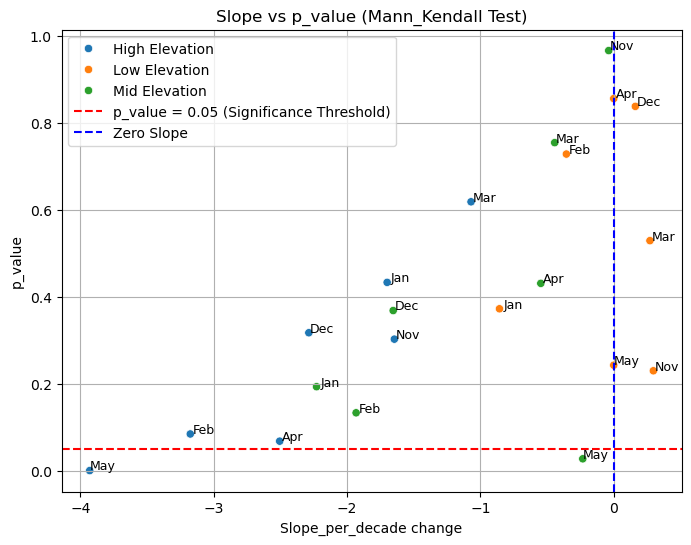

In [28]:
mk_elev_month_simple['month_name'] = mk_elev_month_simple['month'].apply(get_month_name)


fig2, ax2 = plt.subplots(figsize=(8,6))



sns.scatterplot(data=mk_elev_month_simple, x='slope_per_decade',y='p',hue='elevation_band', ax=ax2 )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

for i, row in mk_elev_month_simple.iterrows():
    ax2.text(
        row['slope_per_decade'] +0.1 ,
        row['p'] + 0.01,
        row['month_name'],        # Display month
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        fontweight='normal'
    )


ax2.legend()
ax2.set_ylabel('p_value')
ax2.set_xlabel('Slope_per_decade change')
ax2.set_title('Slope vs p_value (Mann_Kendall Test)')
ax2.grid(True)

plt.show()